# **Smart Cities - Building Thermics report**

Clément Bertrou
Aymeric Klos
Elza Diab
Rose Gibert

25/05/2025

# **Modelling**

**Hypothesis**

To run the simulation we will use the following hypothesis. We are assuming that the surface temperature on each wall or part of the wall is uniform.  We will only use one-dimensional heat transfer in each wall or part of the wall and it will be considered to be a linear phenomenon. We have a diffuse distribution of solar radiation within rooms. We will also neglect LW radiation exchange between outer surfaces and the ground. Finally, we consider that there is no heat flow coming from the users, and we neglect air and class heat capacities.

\\


**Room plan**

We will model and study a 32.1 m2 square room integrated into a building, with only one window overlooking the exterior, with 3 walls composed of insulation (yellow), a transparent wall that corresponds to a window (green). Our room contains a smaller room, a toilet, which is 3.1 m2, with a wooden door to pass from one room to another, walls composed of insulant (grey) and placo (blue) between the small room and the big one. The floor and ceiling are adiabatic


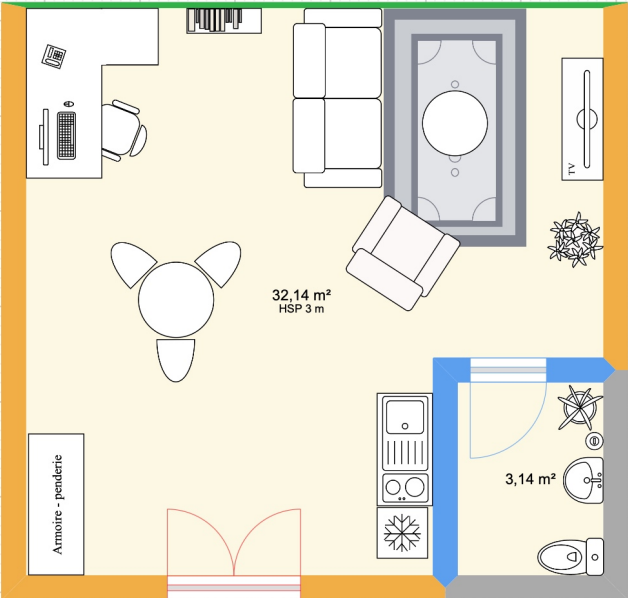

**Composition of the walls and floor**

The walls separating our large room from the rest of the building are made of concrete, a layer of insulation and a layer of placo, with a thickness of 0.25 m. The walls separating our rooms are composed of insulation with two layers of placo around them. The window is made of glass, and is 0.05 m thick. The floors are made of wood for the large room and tiles for the small one, with thicknesses of 0.015 m and 0.05 m respectively.

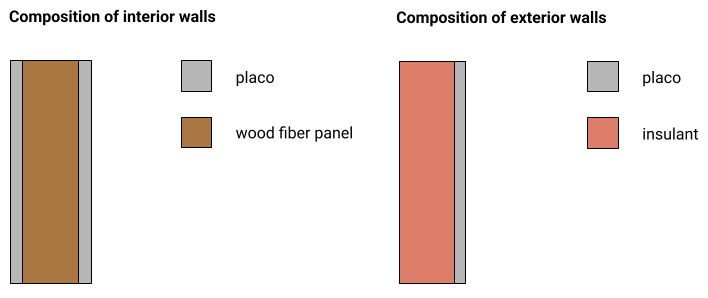

We will then make an assumption to simplify the composition of the exterior wall : we consider that the concrete constitutes a structure that frames the insulating wall, and we neglect the placo layer. Thus the values ​​considered for specific heat, thermal capacity and density are those of the insulation for the exterior, and those of the wood fiber panel for the interior.

We are giving the lambdas, specific heat capacities and density for air, glass, our walls, and a wooden door made out of scots pine, which is the best compromise between insulation and lightness, while being relatively inexpensive.

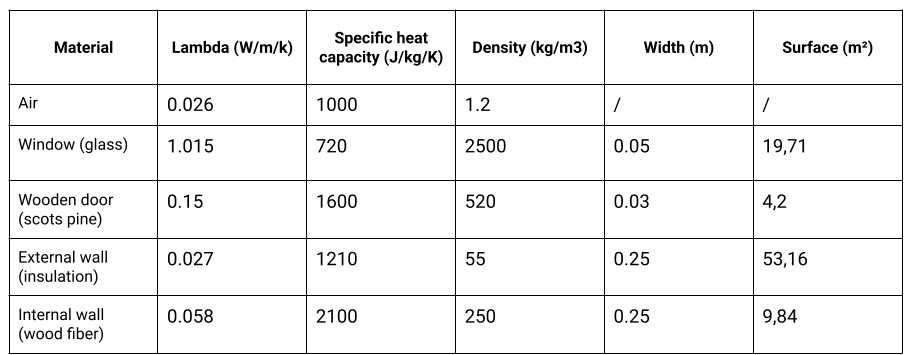
\\

For each wall, we consider an "n" shaped structure made of concrete and for which the panel is filled with insulation. We neglect the concrete structure and thus only consider the insulation.
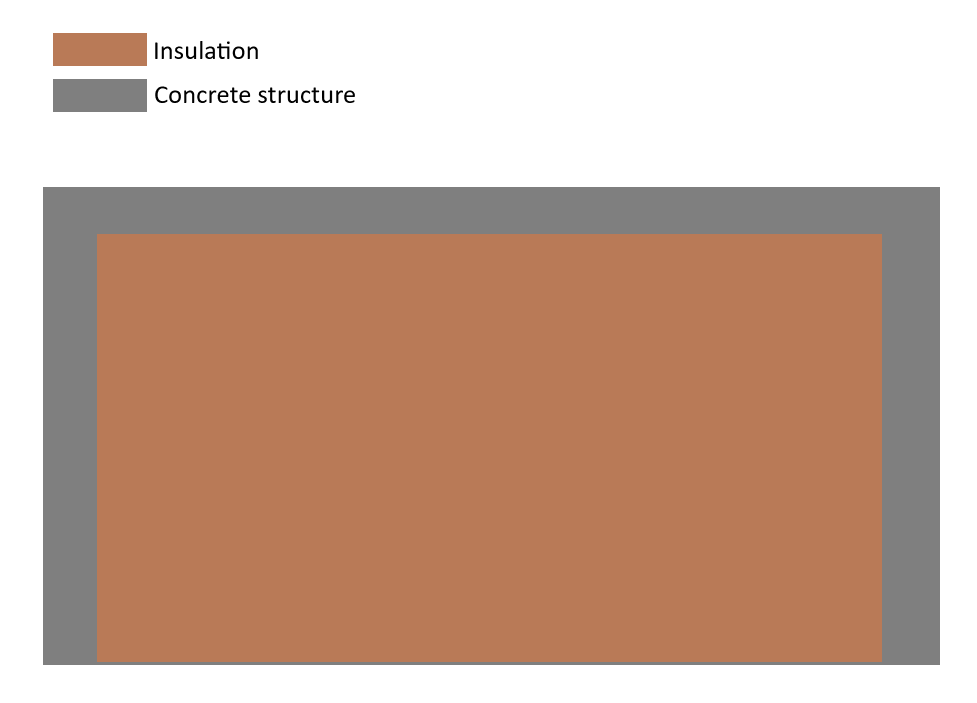

\\


Here is the thermal circuit that modelises our building.

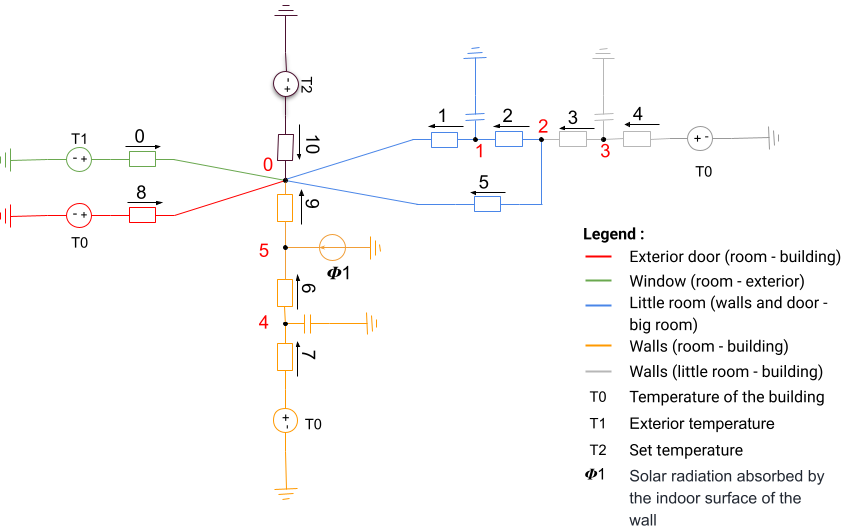

# **Python Model**

In the following lines, we define the different parameters of our simulation, notabely the input temperatures and heat flux, the walls properties.
It also calculates the convection and conduction of the different materials and rooms.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

import time

from dm4bem import read_epw, sol_rad_tilt_surf

HSP= 3 #m
h = 8 # W/(m²⋅K)

air = {'Conductivity': 0.026,              # W/(m·K)
       'Density': 1.2,                     # kg/m³
       'Specific heat': 1000,             # J/(kg·K)
       'Width': 0,                     # m (non spécifié)
       'Surface': 0}                   # m² (non spécifiée)

window = {'Conductivity': 1.015,           # W/(m·K)
          'Density': 2500,                 # kg/m³
          'Specific heat': 720,            # J/(kg·K)
          'Width': 0.05,                   # m
          'Surface': 6.57 * HSP}           # m²

entry_door = {'Conductivity': 0.15,        # W/(m·K)
              'Density': 520,              # kg/m³
              'Specific heat': 1600,       # J/(kg·K)
              'Width': 0.03,               # m
              'Surface': 1.4 * HSP}        # m²

small_door = {'Conductivity': 0.15,        # W/(m·K)
              'Density': 520,              # kg/m³
              'Specific heat': 1600,       # J/(kg·K)
              'Width': 0.03,               # m
              'Surface': 1.4 * HSP}        # m²

external_wall = {'Conductivity': 0.027,    # W/(m·K)
                 'Density': 55,            # kg/m³
                 'Specific heat': 1210,    # J/(kg·K)
                 'Width': 0.2,             # m
                 'Surface': 13.39 * HSP}   # m²
external_wall2 = {'Conductivity': 0.027,    # W/(m·K)
                 'Density': 55,            # kg/m³
                 'Specific heat': 1210,    # J/(kg·K)
                 'Width': 0.2,             # m
                 'Surface': 4.33 * HSP}   # m²

internal_wall = {'Conductivity': 0.058,    # W/(m·K)
                 'Density': 250,           # kg/m³
                 'Specific heat': 2100,    # J/(kg·K)
                 'Width': 0.08,            # m
                 'Surface': 3.28 * HSP}    # m²



wall = pd.DataFrame.from_dict({'external_wall': external_wall,
                               'external_wall2': external_wall2,
                               'internal_wall': internal_wall,
                               'small_door': small_door,
                               'entry_door':entry_door,
                               'window':window},
                              orient='index')
wall

# convection
Gconv = h * wall['Surface'].iloc[0]     # convection pour un mur


# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])

# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

rho_air= 1.02
c_air=1005

S = external_wall['Surface'] + external_wall2['Surface'] + internal_wall['Surface']    # m², wall surface area

λ = 1.0     # W/(m·K), thermal conductivity
ho = 25.0   # W/(m²·K), outside convection coefficient
hi = 8.0    # W/(m²·K), outside convection coefficient
α = 0.70    # -, absorbtance of outdoor surface
E = 200.0   # W/m², solar irradiance on the outdoor surface

#Input temperatures
T0 = 12  # °C, neighbor air temperature
print("La température du voisinage est de:", T0, "°C")
T1 = 10   # °C, outside air temperature
print("La température extérieure est de:", T1, "°C")
T2 = 20 # °C, HVAC air temperature
print("La température en consigne est de:", T2,"°C")

#Input heat-flow
Φ1=1000

Ufenetre= 4
Usmallporte=3.2
Uentryporte=1.6

ACH = 5
V= 96.09 #volume en m3
rho= 1.02 #de l'air à 20 degrés kg/m3
c= 1005 # J/kg/degrésC
K = 1000000 #proportional gain of the HVAC


print("\nThermal conductance for conduction :")
display(G_cd)

print("\nThe thermal conductance for convection for a wall is",Gconv)


ModuleNotFoundError: No module named 'dm4bem'

**System of algebraic-differential equations (DAE)**

The analysis of a thermal circuit, or the direct problem (Ghiaus 2022), means to find the temperatures in the nodes,θ
, and the heat flows on the branches,q
, i.e. to solve for θ and q the system of Differential-Algebraic Equations (DAE) :
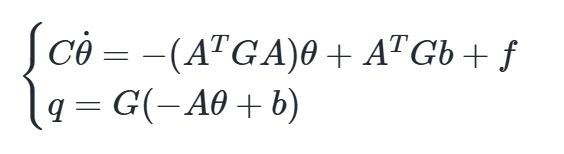


where:

* θ is the temperature vector of size nₜheta, equal to the number of nodes.

* q is the heat flow vector of size n_q, equal to the number of branches.

* A is the incidence matrix of size n_q rows and nₜheta columns, where n_q is the number of flow branches and nₜheta is the number of temperature nodes. It indicates how temperature nodes are connected by oriented branches of heat flow:

  * If flow m enters node n, then element (m, n) of matrix A is 1, i.e., Aₘₙ = 1.

  * If flow m exits node n, then Aₘₙ = -1.

  * If flow m is not connected to node n, then Aₘₙ = 0.

* G is the conductance diagonal matrix of size n_q × n_q, containing the conductance of each branch. For each branch k, the diagonal entry must satisfy:
0 < Gₖₖ < ∞.

* C is the capacity diagonal matrix of size nₜheta × nₜheta, representing the thermal capacities at each node. If a node n has no capacity, then Cₙₙ = 0.

* b is the temperature source vector of size n_q. If there is no temperature source on branch m, then bₘ = 0.

* f is the heat flow source vector of size nₜheta. If there is no heat flow source in node n, then fₙ = 0.

The system is first solved for the temperatures θ, using the following equation:

    C·θ̇ = – (AᵀGA)·θ + AᵀGb + f

This represents a system of differential-algebraic equations (DAE). Once the temperatures are found, the heat flow rates q can be determined from the corresponding equation.

Here's the python code :

In [ ]:
# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5']

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10']

# Incidence matrix

A = np.zeros([11, 6])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = 1, -1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = 1, -1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = 1, -1    # branch 3: node 2 -> node 3
A[4, 3] = 1    # branch 4: node 3 -> node 4
A[5, 2], A[5, 0] = -1, 1    # branch 5: node 4 -> node 5
A[6, 5], A[6, 4] = 1, -1    # branch 6: node 4 -> node 6
A[7, 4]= 1    # branch 7: node 5 -> node 6
A[8, 0] = 1                 # branch 8: -> node 7
A[9, 0], A[9,5]= 1,-1    # branch 9: node 5 -> node 7
A[10, 0] = 1                # branch 10: -> node 6

# Conductance matrix
G = np.array(np.hstack(
    [Ufenetre* wall['Surface'].iloc[5] + rho_air*c_air*ACH*V/3600,
     2 * G_cd['internal_wall'], 2 * G_cd['internal_wall'],
     2 * G_cd['external_wall2'], 2 * G_cd['external_wall2'],
     Usmallporte*wall['Surface'].iloc[3],
     2 * G_cd['external_wall'], 2 * G_cd['external_wall'],
     Uentryporte*wall['Surface'].iloc[4],
     Gconv,
     K]))
Diag_G =np.diag(G)

#Capacity matrix
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Capacity'])

C['Air'] = air['Density'] * air['Specific heat'] * V
pd.DataFrame(C, columns=['Capacity'])

C = np.array([0, C['internal_wall'], 0, C['external_wall2'], C['external_wall'], 0]) #on n' a pas mis la capacité thermique de l'air dans le vecteur C

# Temperature source vector
b = np.array([T1, 0,0,0, T0, 0, 0, T0, T0, 0, T2])

# Flow-rate source vector
f = pd.Series([0, 0, 0, 0, 0, 'Φ1'],
              index=θ)

# Output vector
y = np.zeros(6)         # nodes
y[[0]] = 1
y[[2]] = 1         # nodes (temperatures) of interest
pd.DataFrame(y, index=θ)

# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

print("The incidence matrix A is:")
display(A)
print("\n")
print("\n")
print("conductance matrix G is:")
display(G)
print("\n")
print("\n")
print("the capacity matrix is")
display(C)
print("\n")
print("\n The input vector b is : ")
display(b)
print("\n")
print("The heat flow source vector f is : (Only the solar radiation absorbed by the indoor surface of the wall).")
display(f)

# **Steady state analysis**

**Steady-state from differential algebraic equations (DAE)**

Let's set the neighbour's room temperature (T0) to 10°C

In [ ]:

##Steady-state from differential algebraic equations (DAE)


bss = np.zeros(11)        # temperature sources b for steady state
bss[[4, 7, 8]] = 12      # neighboor temperature =10
bss[[10]] = 20            # indoor set-point temperature

fss = np.zeros(6)         # flow-rate sources f for steady state

diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θ = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θ = {np.around(θ, 2)} °C')




**Steady-state from state-space representation**


In [ ]:
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
print(Cs)
imposed_time_step = True
Δt = 498    # s, imposed time step


In [ ]:
##Steady-state from state-space representation

bT = np.array([T1, T0, T0, T0, T2])
fQ = np.array([Φ1])
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')



inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss
yss = float(yss.values[0])
print(f'yss = {yss:.2f} °C')



Error between the steady-state values obtained from the system of DAE

In [ ]:
##Error between the steady-state values obtained from the system of DAE

print(f'Error between DAE and state-space: {abs(θ[0] - yss):.2e} °C')


**Eigenvalues analysis**

Time step, Duration and Settling time

In [ ]:
# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

# time step
Δtmax = 2 * min(-1. / λ)    # max time step for stability of Euler explicit
dm4bem.print_rounded_time('Δtmax', Δtmax)

if imposed_time_step:
    dt = Δt
else:
    dt = dm4bem.round_time(Δtmax)
dm4bem.print_rounded_time('dt', dt)


if dt < 10:
    raise ValueError("Time step is too small. Stopping the script.")

# settling time
t_settle = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)


In [ ]:
#Step response to outdoor temperature


# Vecteur de temps
n = int(np.floor(duration / dt))
time = pd.date_range(start="2000-01-01 00:00:00", periods=n, freq=f"{int(dt)}s")

# Initialisation des données
T0 = 12 * np.ones(n)
T1 = 10 * np.ones(n)
T2 = 20 * np.ones(n)
Φ1 = 1000 * np.ones(n)

# Création du DataFrame
data = {
    'q0': T1,
    'q4': T0,
    'q7': T0,
    'q8': T0,
    'q10': T2,
    'θ5': T1  # ou T0, selon votre choix
}
input_data_set = pd.DataFrame(data, index=time)


# inputs in time from input_data_set
u = input_data_set[us.index]
print(u)

#u = dm4bem.inputs_in_time(us, input_data_set)

In [ ]:
#Time integration

# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 0.0                    # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])


# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T
# Select the desired output column (e.g., 'θ0')
y_exp_theta2 = y_exp['θ2']
y_imp_theta2 = y_imp['θ2']


# Combine only the selected output for Explicit and Implicit results for plotting
y = pd.concat([y_exp_theta2, y_imp_theta2], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)

# Plot the results
ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
# Ensure dt and Δtmax are defined if you want to include them in the title
# ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()

print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[0]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: \
{y_exp["θ2"].tail(1).values[0]:.4f} °C')

**Discussion**

Influence of time step

**Weather**

In [ ]:
start_date = '02-01 12:00:00'
end_date = '02-07 18:00:00'
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

# Temperature sources
T1 = weather['temp_air']

# total solar irradiance
external_wall = pd.read_csv('./bldg/external_wall.csv')
w0 = external_wall[external_wall['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['albedo'].values[0])

Etot = rad_surf.sum(axis=1)

S_g = 9         # m², surface area of glass

# solar radiation absorbed by the outdoor surface of the wall
Φo = w0['α1'].values[0] * w0['Area'].values[0] * Etot


# solar radiation absorbed by the indoor surface of the wall
Φi = τ_gSW * w0['α0'].values[0] * S_g * Etot

# solar radiation absorbed by the glass
Φa = α_gSW * S_g * Etot



**Schedules**

In [ ]:
# indoor air temperature set-point
T2 = pd.Series(20, index=T1.index)

Ti_day, Ti_night = 20, 16

T2 = pd.Series(
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in T1.index.hour],
    index=T1.index)

# Ensure T0 and Φ1 have the same index as the other variables
T0 = pd.Series(12, index=T1.index)
Φ1 = pd.Series(1000, index=T1.index)

# Input data set
input_data_set = pd.DataFrame({'T0': T0, 'T1': T1, 'T2': T2, 'Φ1': Φ1,
                               'Etot': Etot})
input_data_set.to_csv('./input_data_set.csv')

**Simulation: perfect controller**

In [ ]:
controller = True

neglect_air_capacity = True
neglect_glass_capacity = True

explicit_Euler = True

imposed_time_step = False
Δt = 3600    # s, imposed time step

# MODEL

# by default TC['G']['q11'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q11'] = K     # G11 = Kp, conductance of edge q11
                            # Kp -> ∞, almost perfect controller
if neglect_air_capacity:
    TC['C']['θ6'] = 0       # C6, capacity of vertex θ6 (air)
if neglect_glass_capacity:
    TC['C']['θ7'] = 0       # C7, capacity of vertex θ7 (glass)


λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)

**Input data set**

In [ ]:
# Flow-rate sources from f (in order of node index): θ5 (Φ1)

# The actual mapping depends on the internal logic of dm4bem.tc2ss.
# However, if the state-space inputs correspond to the non-zero entries
# of the b and f vectors in that order, the mapping should be:
us = pd.Series(['T1', 'T0', 'T0', 'T0', 'T2', 'Φ1'],
               index=[0, 1, 2, 3, 4, 5]) # Assuming 6 state-space inputs

# INPUT DATA SET
# ==============
input_data_set = pd.read_csv('./input_data_set.csv',
                             index_col=0,
                             parse_dates=True)
input_data_set
freq_str = f"{int(dt)}s"
input_data_set = input_data_set.resample(freq_str).interpolate(method='linear')

input_data_set.head()

# Input vector in time from input_data_set
# Now, dm4bem.inputs_in_time should look up the correct columns in input_data_set
# using the values in the manually corrected us Series.
u = dm4bem.inputs_in_time(us, input_data_set)
u.head()

print(u)


**Initial conditions**

In [ ]:
# Initial conditions
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0
for k in range(u.shape[0] - 1):
    # Calculer le nouveau vecteur d'état (résultat est un tableau NumPy)
    new_state_np = (I + dt * As) @ θ.iloc[k].values + dt * Bs @ u.iloc[k].values

    # Convertir le tableau NumPy en une Série Pandas avec les mêmes noms de colonnes que θ
    new_state_series = pd.Series(new_state_np, index=θ.columns)

    # Assigner la Série au DataFrame θ à la ligne k+1
    θ.iloc[k + 1] = new_state_series


# Calculer le résultat du modèle d'espace d'état (tableau NumPy)
y_np = (Cs.values @ θ.T.values + Ds.values @  u.T.values).T

# Convertir le tableau NumPy en DataFrame Pandas en utilisant les noms de colonnes de Cs
y = pd.DataFrame(y_np, index=u.index, columns=Cs.index)


Kp = K
S = 9                   # m², surface area of the toy house
q_HVAC = Kp * (u.loc[:, 5] - y['θ0']) / S  # W/m²
y['θ0']

*PLOT*

In [ ]:
data = pd.DataFrame({'T1': input_data_set['T1'],
                     'θ2': y['θ2']})

fig, ax = plt.subplots(figsize=(10, 6))
data[['T1', 'θ2']].plot(ax=ax,
                        ylabel='Temperature, $θ$ / °C')
ax.legend(['$θ_{outdoor}$', '$θ_{Small room}$'],
              loc='upper right')

ax.set_xlabel('Time')

plt.show();

Figure2: Simulation of the free running with the explicit Euler showing the variation temperature of the small room.

In [ ]:
data = pd.DataFrame({'T1': input_data_set['T1'],
                     'θ0': y['θ0']})

fig, ax = plt.subplots(figsize=(10, 6))
data[['T1', 'θ0']].plot(ax=ax,
                        ylabel='Temperature, $θ$ / °C')
ax.legend(['$θ_{outdoor}$', '$θ_{Big room}$'],
              loc='upper right')

ax.set_xlabel('Time')

plt.show();

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data_Etot = pd.DataFrame({'Etot': Etot}, index=input_data_set.index)

fig_Etot, ax_Etot = plt.subplots(figsize=(10, 6))

data_Etot['Etot'].plot(ax=ax_Etot,
                           ylabel='Heat rate, Etot / (W·m⁻²)')

ax_Etot.set_xlabel('Time')
ax_Etot.set_title('Tracé de Etot')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data_q_hvac = pd.DataFrame({'q_HVAC': q_HVAC}, index=input_data_set.index)

fig_q_hvac, ax_q_hvac = plt.subplots(figsize=(10, 6))

data_q_hvac['q_HVAC'].plot(ax=ax_q_hvac,
                           ylabel='Heat rate, $q_{HVAC}$ / (W·m⁻²)')

ax_q_hvac.set_xlabel('Time')
ax_q_hvac.set_title('Tracé de $q_{HVAC}$')

plt.show()

In [ ]:
!pip install control==0.9.0


**DISCUSSION**

In [ ]:
import time
import control as ctrl
import numpy as np

sys = ctrl.ss(As.values, Bs.values, Cs.values, Ds.values)


θ0_sim_np = θ0



u_np_ctrl = u.values.T       # inputs in time (transposés pour la librairie control)


t_np = (u.index - u.index.min()).total_seconds().values


start_time = time.time()


t_ctrl, yout_ctrl, xout_ctrl = ctrl.forced_response(sys, T=t_np, U=u_np_ctrl, X0=θ0_sim_np, return_x=True)

end_time = time.time()
duration_1 = end_time - start_time

start_time = time.time()

# Euler explicit
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0
for k in range(u.shape[0] - 1):
    # Calculer le nouveau vecteur d'état (résultat est un tableau NumPy)
    new_state_np = (I + dt * As) @ θ.iloc[k].values + dt * Bs @ u.iloc[k].values

    # Convertir le tableau NumPy en une Série Pandas avec les mêmes noms de colonnes que θ
    new_state_series = pd.Series(new_state_np, index=θ.columns)

    # Assigner la Série au DataFrame θ à la ligne k+1
    θ.iloc[k + 1] = new_state_series


# Calculer le résultat du modèle d'espace d'état (tableau NumPy)
y_np = (Cs.values @ θ.T.values + Ds.values @  u.T.values).T

# Convertir le tableau NumPy en DataFrame Pandas en utilisant les noms de colonnes de Cs
y = pd.DataFrame(y_np, index=u.index, columns=Cs.index)


end_time = time.time()
duration_2 = end_time - start_time

fig, axs = plt.subplots(figsize=(10, 6))

output_name_to_plot = 'θ0'

idx_output_plot = 0

axs.plot(t_ctrl / 3600 / 24, yout_ctrl[idx_output_plot, :], label='Control Systems Library',
         linestyle='--', color='red', linewidth=2, marker='', markersize=4)


axs.plot((y.index - y.index.min()).total_seconds().values / 3600 / 24, # Temps pour Euler
        y[output_name_to_plot].values, label='Euler explicit') # Valeurs de la colonne sélectionnée

axs.set(xlabel='Time, $t$ / day',
        ylabel=f'Temperature, $θ$ / °C (Node {output_name_to_plot})', # Indiquer quel nœud est tracé
        title='Comparison of Control Systems Library with Explicit Euler')
axs.grid(True)
axs.legend()
plt.show()

# Print the comparison of durations
print(f"Duration for Control Systems Library: {duration_1:.2f} seconds")
print(f"Duration for Euler explict:           {duration_2:.2f} seconds")